# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats as st

In [2]:
calls = pd.read_csv("/datasets/megaline_calls.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")
users = pd.read_csv("/datasets/megaline_users.csv")

## Cargar datos

In [3]:
# Carga los archivos de datos en diferentes DataFrames
calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [4]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [5]:
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [6]:
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [7]:
users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


## Preparar los datos

## Tarifas

In [8]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [9]:
# Imprime una muestra de los datos para las tarifas

plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


En general, los dataframes parecen estar normalizados pero aun asi tenemos que agregar formato de fecha para algunas columnas, al igual que tenemos la columna churn_date con valores ausentes pero debido a la naturaleza de la columna, que es cuando el plan se cancelo, no es necesario ya que si aparece un valor no-nulo significa que el servicio sigue activo.

Solo contamos con 2 planes, surf y ultimate. 
* messages_included: Representa la cantidad de mensajes que incluye cada plan.
* mb_per_month_included: Representa la cantidad de mb que incluye cada plan.
* minutes_included: Representa los minutos incluidos en cada plan.
* usd_monthly_pay: Representa la cuota mensual que se cubre del plan.
* usd_per_gb: Representa el costo unitario por gb
* usd_per_message: Representa el costo unitario por mensaje.
* usd_per_minute: Representa el costo unitario por minuto.
* plan_name: Muestra el nombre del plan. 

## Corregir datos

Probaremos que formato tiene cada columna que almacena fechas y corregir al formato de fecha.
Se presenta la lista de las columnas que almacenan fechas (tabla/columna).

* internet / session_date
* calls / call_date
* messages / message_date
* users / reg_date
* users / churn_date

In [10]:
plans["gb_per_month_included"] = plans["mb_per_month_included"]/1024
print(plans["gb_per_month_included"])

0    15.0
1    30.0
Name: gb_per_month_included, dtype: float64


## Enriquecer los datos

## Usuarios/as

In [11]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

users.info()
users.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


In [12]:
users.duplicated().sum()

0

In [13]:
# Imprime una muestra de datos para usuarios

users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


### Corregir los datos

In [14]:
# formato para users / reg_date
users["reg_date"]=pd.to_datetime(users["reg_date"],format="%Y-%m-%d")
# formato para users / churn_date
users["churn_date"]=pd.to_datetime(users["churn_date"],format="%Y-%m-%d")
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Como podemos observar los dtype de las columnas cambiaron a datetime64[ns] indicando que se encuentran en el formato deseado.

### Enriquecer los datos

In [15]:
for df, date_col in zip([calls, internet], ["call_date", "session_date"]):
    print(df, date_col)

              id  user_id   call_date  duration
0        1000_93     1000  2018-12-27      8.52
1       1000_145     1000  2018-12-27     13.66
2       1000_247     1000  2018-12-27     14.48
3       1000_309     1000  2018-12-28      5.76
4       1000_380     1000  2018-12-30      4.22
...          ...      ...         ...       ...
137730  1499_199     1499  2018-11-21      8.72
137731  1499_200     1499  2018-10-20     10.89
137732  1499_201     1499  2018-09-21      8.12
137733  1499_202     1499  2018-10-10      0.37
137734  1499_203     1499  2018-12-29     13.86

[137735 rows x 4 columns] call_date
              id  user_id session_date  mb_used
0        1000_13     1000   2018-12-29    89.86
1       1000_204     1000   2018-12-31     0.00
2       1000_379     1000   2018-12-28   660.40
3       1000_413     1000   2018-12-26   270.99
4       1000_442     1000   2018-12-27   880.22
...          ...      ...          ...      ...
104820  1499_215     1499   2018-10-20   218.06
104

## Llamadas

In [16]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas

calls.info()
calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


In [17]:
calls.duplicated().sum()

0

In [18]:
# Imprime una muestra de datos para las llamadas

calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Corregir los datos

In [19]:
# formato para calls / call_date
calls["call_date"]= pd.to_datetime(calls["call_date"],format="%Y-%m-%d")
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


In [20]:
calls["duration"] = np.ceil(calls["duration"])

### Enriquecer los datos

In [21]:
calls["month"] = calls["call_date"].dt.to_period("M").dt.start_time

## Mensajes

In [22]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [23]:
# Imprime una muestra de datos para los mensajes
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


### Corregir los datos

In [24]:
# formato para messages / message_date
messages["message_date"]=pd.to_datetime(messages["message_date"],format="%Y-%m-%d")

messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

In [25]:
messages["month"] = messages["message_date"].dt.to_period("M").dt.start_time

## Internet

In [26]:
# Imprime la información general/resumida sobre el DataFrame de internet

internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [27]:
internet["gb_used"] = internet["mb_used"] / 1024
internet["gb_used"] = np.ceil(internet["gb_used"])

In [28]:
# Imprime una muestra de datos para el tráfico de internet

internet.head()

,id,user_id,session_date,mb_used,gb_used
0,1000_13,1000,2018-12-29,89.86,1.0
1,1000_204,1000,2018-12-31,0.00,0.0
2,1000_379,1000,2018-12-28,660.40,1.0
3,1000_413,1000,2018-12-26,270.99,1.0
4,1000_442,1000,2018-12-27,880.22,1.0


### Corregir los datos

In [29]:
print(type("session_date"))
# formato para internet / session_date
internet["session_date"]= pd.to_datetime(internet["session_date"],format="%Y-%m-%d")
internet.info()

<class 'str'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
 4   gb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 4.0+ MB


In [30]:
internet["month"] = internet["session_date"].dt.to_period("M").dt.start_time


### Enriquecer los datos

## Estudiar las condiciones de las tarifas

In [31]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras

print(plans)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  \
0               20          10             0.03            0.03      surf   
1               70           7             0.01            0.01  ultimate   

   gb_per_month_included  
0                   15.0  
1                   30.0  


## Agregar datos por usuario


In [32]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
calls_by_month= calls.groupby(["user_id","month"]).agg(
    total_calls= ("duration","count"), # Número de llamadas hechas por cada usuario al mes.
    total_minutes= ("duration","sum") # Número de minutos usados por cada usuario al mes.
).reset_index()
calls_by_month.head()

,user_id,month,total_calls,total_minutes
0,1000,2018-12-01,16,124.0
1,1001,2018-08-01,27,182.0
2,1001,2018-09-01,49,315.0
3,1001,2018-10-01,65,393.0
4,1001,2018-11-01,64,426.0


In [33]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
message_by_month= messages.groupby(["user_id","month"]).agg(
    total_messages= ("id","count")).reset_index()
message_by_month.head()

,user_id,month,total_messages
0,1000,2018-12-01,11
1,1001,2018-08-01,30
2,1001,2018-09-01,44
3,1001,2018-10-01,53
4,1001,2018-11-01,36


In [34]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
gb_used_by_month= internet.groupby(["user_id","month"]).agg(
    total_gb_used= ("gb_used", "sum")).reset_index()
gb_used_by_month.head()

,user_id,month,total_gb_used
0,1000,2018-12-01,4.0
1,1001,2018-08-01,21.0
2,1001,2018-09-01,41.0
3,1001,2018-10-01,50.0
4,1001,2018-11-01,49.0


In [35]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

convined_calls_and_mb = pd.merge(
    calls_by_month,
    gb_used_by_month,
    on= ["user_id","month"],
    how= "outer"
)
convined_data= pd.merge(convined_calls_and_mb,
                        message_by_month,
                        on = ["user_id","month"],
                        how = "outer"
                       )
convined_data.head()

,user_id,month,total_calls,total_minutes,total_gb_used,total_messages
0,1000,2018-12-01,16.0,124.0,4.0,11.0
1,1001,2018-08-01,27.0,182.0,21.0,30.0
2,1001,2018-09-01,49.0,315.0,41.0,44.0
3,1001,2018-10-01,65.0,393.0,50.0,53.0
4,1001,2018-11-01,64.0,426.0,49.0,36.0


In [36]:
convined_data.isna().sum()

user_id             0
month               0
total_calls        35
total_minutes      35
total_gb_used      16
total_messages    487
dtype: int64

In [37]:
# Añade la información de la tarifa
# Añadimos la información del df users a nuestro df con la información resumida.
convined_data_with_user_info = pd.merge(convined_data,
                                        users,
                                        on = "user_id",
                                        how= "left"
)
convined_data_with_user_plan = pd.merge(convined_data_with_user_info,
                                        plans,                                       
                                        left_on = "plan",
                                        right_on = "plan_name",
                                        
).drop(columns= "plan_name")


In [38]:
convined_data_with_user_plan["churn_date"] = convined_data_with_user_plan["churn_date"].fillna("0")
print(convined_data_with_user_plan.head())

   user_id      month  total_calls  total_minutes  total_gb_used  \
0     1000 2018-12-01         16.0          124.0            4.0   
1     1006 2018-11-01          2.0           10.0            7.0   
2     1006 2018-12-01          9.0           59.0           62.0   
3     1008 2018-10-01         71.0          476.0           48.0   
4     1008 2018-11-01         63.0          446.0           56.0   

   total_messages first_name last_name  age  \
0            11.0   Anamaria     Bauer   45   
1            15.0     Jesusa  Bradford   73   
2           139.0     Jesusa  Bradford   73   
3            21.0      Emely   Hoffman   53   
4            37.0      Emely   Hoffman   53   

                                     city  ...      plan           churn_date  \
0   Atlanta-Sandy Springs-Roswell, GA MSA  ...  ultimate                    0   
1  San Francisco-Oakland-Berkeley, CA MSA  ...  ultimate  2018-12-18 00:00:00   
2  San Francisco-Oakland-Berkeley, CA MSA  ...  ultimate  2018-12

In [39]:
# Calcula el ingreso mensual para cada usuario

behavior_data = convined_data_with_user_plan.copy()

# Excedente minutos
behavior_data["excess_minutes"]= behavior_data["total_minutes"] - behavior_data["minutes_included"] #Se calcula la diferencia de minutos con los incluidos en el plan
behavior_data.loc[behavior_data["excess_minutes"] < 0, "excess_minutes"]= 0 #Si el excedente no sobrepasa el plan, se trunca a 0

# Excedente mb

behavior_data["excess_gb"]= behavior_data["total_gb_used"] - behavior_data["gb_per_month_included"]
behavior_data.loc[behavior_data["excess_gb"] < 0, "excess_gb"]= 0 #igualamos a cero las filas que no exceden los mb del plan


# Excedente mensaje

behavior_data["excess_messages"] = behavior_data["total_messages"] - behavior_data["messages_included"]
behavior_data.loc[behavior_data["excess_messages"] <0, "excess_messages"]=0


#Calculo de ingreso

behavior_data["income"] = behavior_data["usd_monthly_pay"]
behavior_data["income"] += behavior_data["excess_minutes"] * behavior_data["usd_per_minute"]
behavior_data["income"] += behavior_data["excess_gb"]* behavior_data["usd_per_gb"]
behavior_data["income"] += behavior_data["excess_messages"]* behavior_data["usd_per_message"]

behavior_data[["user_id", "plan", "month", "income", "usd_per_gb", "excess_gb", "usd_per_minute", "excess_minutes", "excess_messages", "usd_per_message"]].head(20)


,user_id,plan,month,income,usd_per_gb,excess_gb,usd_per_minute,excess_minutes,excess_messages,usd_per_message
0,1000,ultimate,2018-12-01,70.0,7,0.0,0.01,0.0,0.0,0.01
1,1006,ultimate,2018-11-01,70.0,7,0.0,0.01,0.0,0.0,0.01
2,1006,ultimate,2018-12-01,294.0,7,32.0,0.01,0.0,0.0,0.01
3,1008,ultimate,2018-10-01,196.0,7,18.0,0.01,0.0,0.0,0.01
4,1008,ultimate,2018-11-01,252.0,7,26.0,0.01,0.0,0.0,0.01
5,1008,ultimate,2018-12-01,140.0,7,10.0,0.01,0.0,0.0,0.01
6,1011,ultimate,2018-06-01,70.0,7,0.0,0.01,0.0,0.0,0.01
7,1011,ultimate,2018-07-01,266.0,7,28.0,0.01,0.0,0.0,0.01
8,1011,ultimate,2018-08-01,266.0,7,28.0,0.01,0.0,0.0,0.01
9,1011,ultimate,2018-09-01,175.0,7,15.0,0.01,0.0,0.0,0.01


Se comparo el consumo en cada uno de los servicio contra lo incluido en el plan de cada usuario mensualmente. A esa diferencia, se le aplico un filtro para que solo los valores exedentes del plan se multiplicaran por el costo unitario del servicio exedido, para finalmente agregar ese monto a la suma total que debe pagar cada usuario mentusalmente.
De este modo obteniendo el monto que cada usuario debe pagar por el consumo de su servicio cada mes.


## Estudia el comportamiento de usuario

### Llamadas

In [40]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
surf_behavior= behavior_data.query('plan=="surf"')
ultimate_behavior = behavior_data.query('plan=="ultimate"')


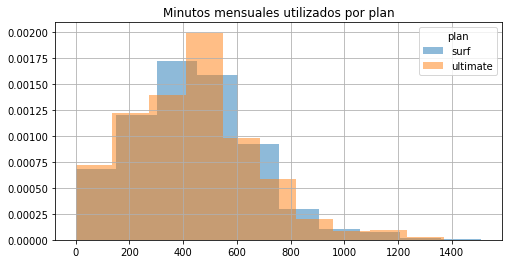

In [41]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
plt.figure(figsize=(8,4))
surf_behavior["total_minutes"].hist(ax=plt.gca(),density=True, alpha=0.5, label="surf")
ultimate_behavior["total_minutes"].hist(ax=plt.gca(),density=True, alpha=0.5, label="ultimate")
plt.legend(title="plan")
plt.title("Minutos mensuales utilizados por plan")
plt.show()


In [42]:
total_minutes_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "total_minutes",
                                                   aggfunc='sum'
) 


<AxesSubplot:title={'center':'Minutos mensuales utilizados por plan'}, xlabel='month'>

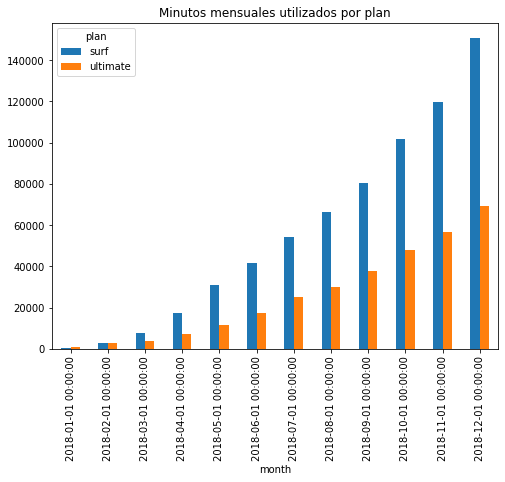

In [43]:
total_minutes_by_month.plot(kind="bar",figsize= (8,6), title= "Minutos mensuales utilizados por plan")

In [44]:
mean_minutes_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "total_minutes",
                                                   aggfunc='mean'
) 

<AxesSubplot:title={'center':'Minutos promedio mensuales utilizados por plan'}, xlabel='month'>

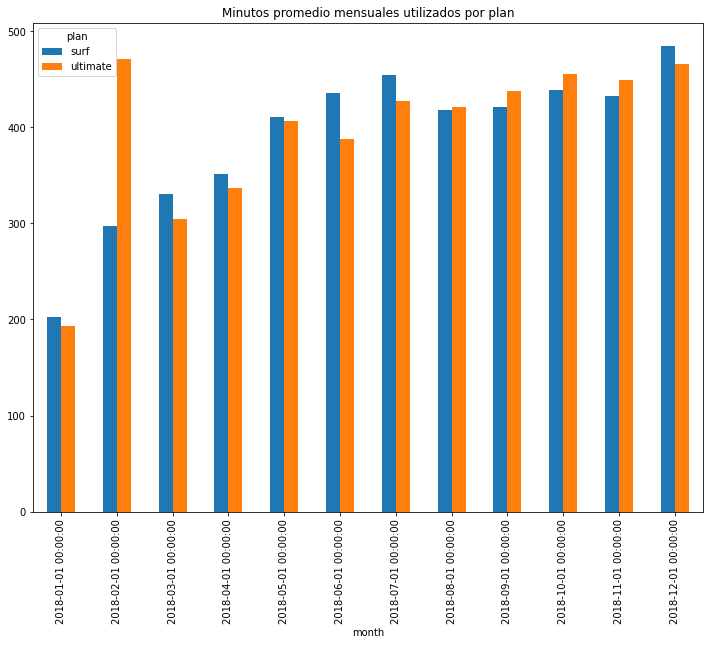

In [45]:
mean_minutes_by_month.plot(kind="bar",figsize= (12,9), title= "Minutos promedio mensuales utilizados por plan")

In [46]:
print("la media de consumo de los usuarios Surf es de" , surf_behavior["total_minutes"].mean())

la media de consumo de los usuarios Surf es de 436.51974110032364


In [47]:
print("la media de consumo de los usuarios ultimate es de" ,ultimate_behavior["total_minutes"].mean())

la media de consumo de los usuarios ultimate es de 434.67601683029454


In [48]:
var_minutes_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "total_minutes",
                                                   aggfunc='var'
) 

<AxesSubplot:title={'center':'Varianza mensual utilizados por plan'}, xlabel='month'>

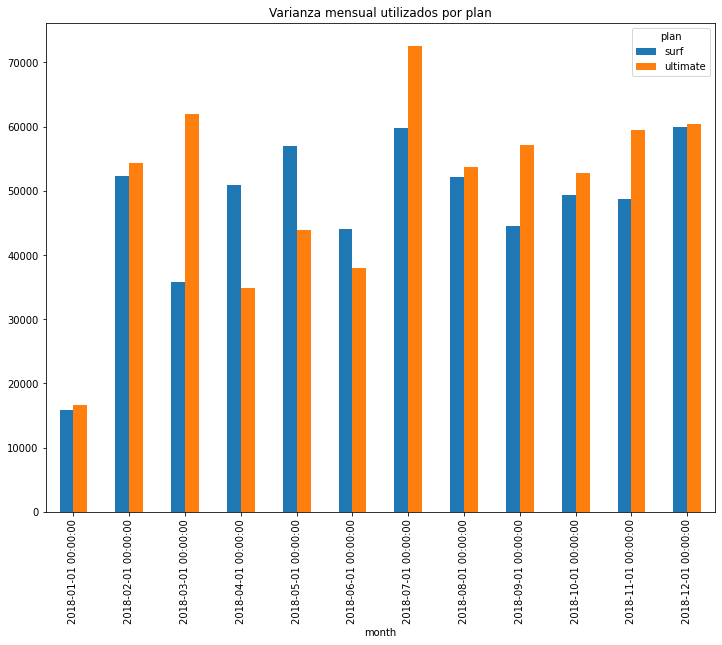

In [49]:
var_minutes_by_month.plot(kind="bar",figsize= (12,9), title= "Varianza mensual utilizados por plan")

In [50]:
surf_var_minutes = surf_behavior["total_minutes"].var()
surf_std_minutes = np.sqrt(surf_var_minutes)
print("La varianza entre los minutos totales por usuario es de",surf_var_minutes)
print("La desviación estandar de los datos es ", surf_std_minutes)

La varianza entre los minutos totales por usuario es de 52571.06324345624
La desviación estandar de los datos es  229.28380501783428


In [51]:
ultimate_var_minutes = ultimate_behavior["total_minutes"].var()
ultimate_std_minutes = np.sqrt(ultimate_var_minutes)
print("La varianza entre los minutos totales por usuario es de",ultimate_var_minutes)
print("La desviación estandar de los datos es ", ultimate_std_minutes)

La varianza entre los minutos totales por usuario es de 56573.63224703341
La desviación estandar de los datos es  237.85212264563336


Obtenemos que la varianza en ambos casos se parecen, sin embargo, la diferiencia entre la media y la varianza es significativa, demostrando que el rango de nuestros datos es amplio, esto se puede deber a que es sumamente variable el tiempo que los usuarios pasan hablando por telefono. Mientras que la población joven prefiere los mensajes de texto, la gente mayor prefiere el telefo, seria interesante contar con las edades de edades de los usuarios para probar esta hipotesis.

Por otro lado, la desviación estandar demuestra que los datos estan dispersos, ya que la diferencia entre la media y la desviación estandar es grande.

<AxesSubplot:xlabel='total_minutes'>

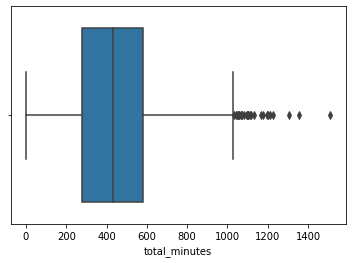

In [52]:
# Traza un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

sns.boxplot(x=surf_behavior["total_minutes"])


<AxesSubplot:xlabel='total_minutes'>

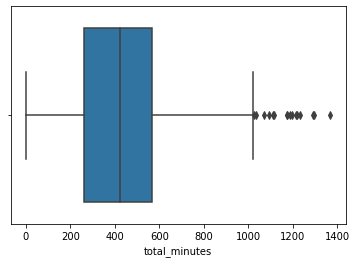

In [53]:
sns.boxplot(x=ultimate_behavior["total_minutes"])

Con los gráficos de bigotes podemos observar que los valores de la media como las Q3 son similares con lo que reforzamos nuestra hipotesis de que no se aprecia una diferencia significante entre ambos planes en lo que conlleva a los minutos consumidos.

Como logramos apreciar en el grafico no parece haber mucha diferencia en el comportamiento de los 

### Mensajes

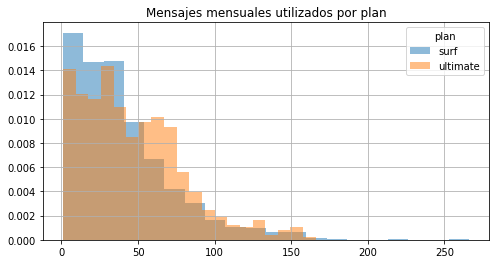

In [54]:
# Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan


plt.figure(figsize=(8,4))
surf_behavior["total_messages"].hist(ax=plt.gca(),bins=20, density=True, alpha=0.5, label="surf")
ultimate_behavior["total_messages"].hist(ax=plt.gca(),bins=20, density=True, alpha=0.5, label="ultimate")
plt.legend(title="plan")
plt.title("Mensajes mensuales utilizados por plan")
plt.show()


In [55]:
total_messages_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "total_messages",
                                                   aggfunc='sum'
) 


<AxesSubplot:title={'center':'Total de mensajes mensuales utilizados por plan'}, xlabel='month'>

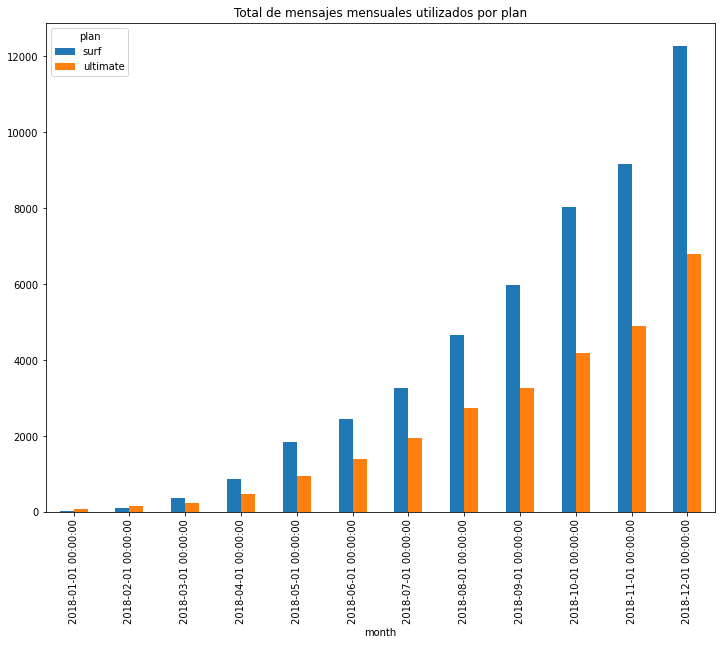

In [56]:
total_messages_by_month.plot(kind="bar",figsize= (12,9), title= "Total de mensajes mensuales utilizados por plan")

In [57]:
mean_messages_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "total_messages",
                                                   aggfunc='mean'
) 

<AxesSubplot:title={'center':'Mensajes promedio por mes utilizados por plan'}, xlabel='month'>

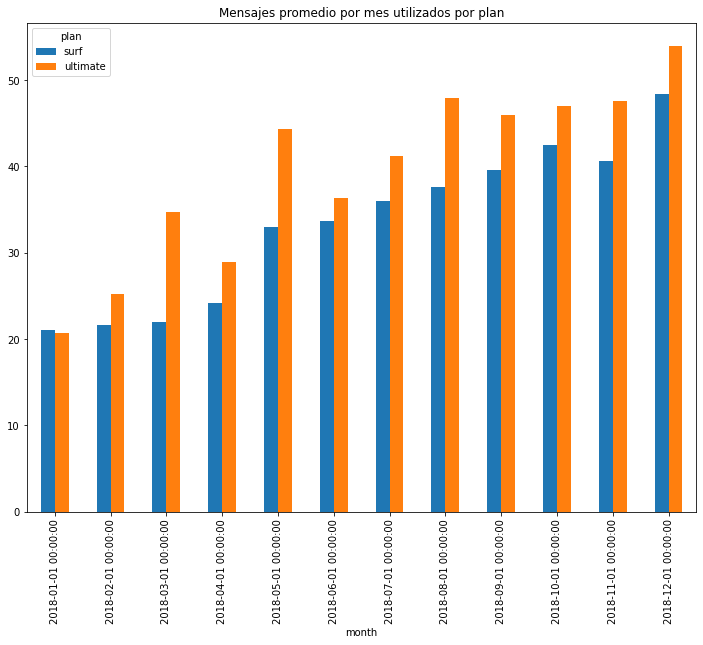

In [58]:
mean_messages_by_month.plot(kind="bar",figsize= (12,9), title= "Mensajes promedio por mes utilizados por plan")

In [59]:
print("la media de consumo de mensajes de los usuarios Surf es de" , surf_behavior["total_messages"].mean())

la media de consumo de mensajes de los usuarios Surf es de 40.10965630114566


In [60]:
print("la media de consumo de mensajes de los usuarios Ultimate es de" , ultimate_behavior["total_messages"].mean())

la media de consumo de mensajes de los usuarios Ultimate es de 46.29623287671233


In [61]:
surf_var_messages = surf_behavior["total_messages"].var()
surf_std_messages = np.sqrt(surf_var_messages)
print("La varianza entre los minutos totales por usuarios Surf es de",surf_var_messages)
print("La desviación estandar de los datos es ", surf_std_messages)

La varianza entre los minutos totales por usuarios Surf es de 1091.3442310038054
La desviación estandar de los datos es  33.03549955735202


In [62]:
ultimate_var_messages = ultimate_behavior["total_messages"].var()
ultimate_std_messages = np.sqrt(ultimate_var_messages)
print("La varianza entre los minutos totales por usuarios ultimate es de",ultimate_var_messages)
print("La desviación estandar de los datos es ", ultimate_std_messages)

La varianza entre los minutos totales por usuarios ultimate es de 1085.183107568317
La desviación estandar de los datos es  32.942117533156804


Podemos observar que el total de mensajes al igual que las llamadas va en aumento al pasar el tiempo, igualmente se aprecia que los usuarios del plan surf tienden a usar mas mensajes de texto. igualmente podemos observar que la desviación estandar es mucho menor y por lo tanto nuestros datos se encuentran menos dispersos, y esto lo podemos comprobar ya que nuestra desviación estandar esta relativamente cerca de la media. Por lo que nuestros datos tienden a ser menos dispersos.

<AxesSubplot:xlabel='total_messages'>

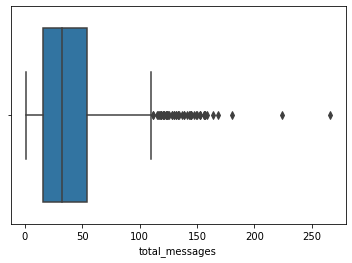

In [63]:
sns.boxplot(x=surf_behavior["total_messages"])

<AxesSubplot:xlabel='total_messages'>

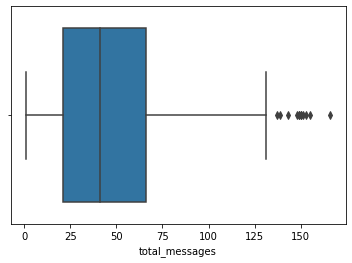

In [64]:
sns.boxplot(x=ultimate_behavior["total_messages"])

Tenemos un efecto similar en el comportamiento de los usuarios en el uso de mensajes entre los dos planes, esta vez tanto la varianza como la media parecen similares.

### Internet

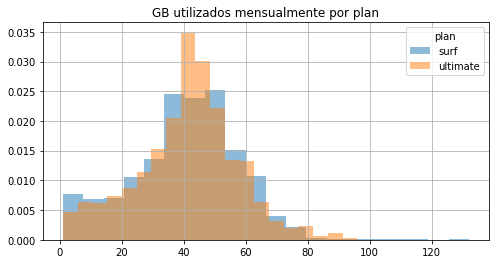

In [65]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan
plt.figure(figsize=(8,4))
surf_behavior["total_gb_used"].hist(ax=plt.gca(),bins=20, density=True, alpha=0.5, label="surf")
ultimate_behavior["total_gb_used"].hist(ax=plt.gca(),bins=20, density=True, alpha=0.5, label="ultimate")
plt.legend(title="plan")
plt.title("GB utilizados mensualmente por plan")
plt.show()

In [66]:
total_gb_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "total_gb_used",
                                                   aggfunc='mean'
) 

<AxesSubplot:title={'center':'Total de GB mensuales utilizados por plan'}, xlabel='month'>

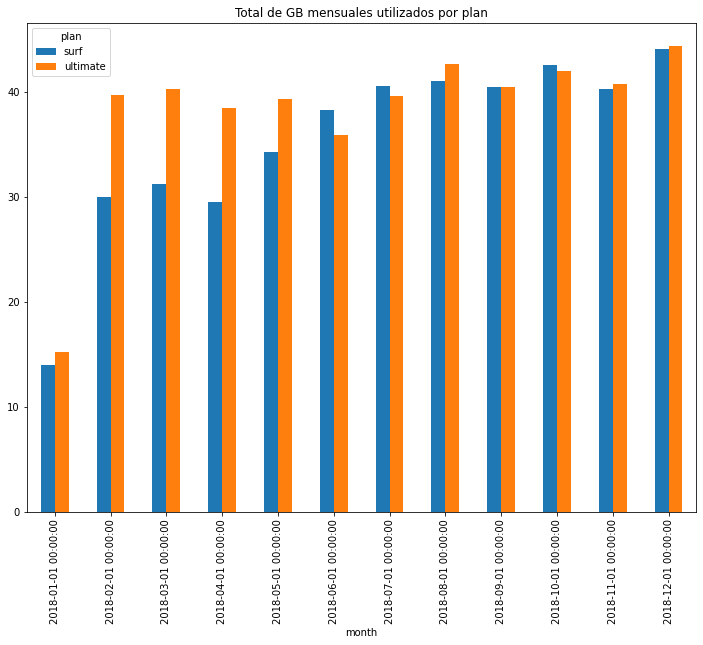

In [67]:
total_gb_by_month.plot(kind="bar",figsize= (12,9), title= "Total de GB mensuales utilizados por plan")

Podemos observar que la diferencia entre los clientes de los diferentes planes parece ser similar, aun asi las columnas del plan ultimate esta vez se aprecia un mayor consumo.

In [68]:
mean_gb_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "total_gb_used",
                                                   aggfunc='mean'
) 

<AxesSubplot:title={'center':'Promedio de GB mensuales utilizados por plan'}, xlabel='month'>

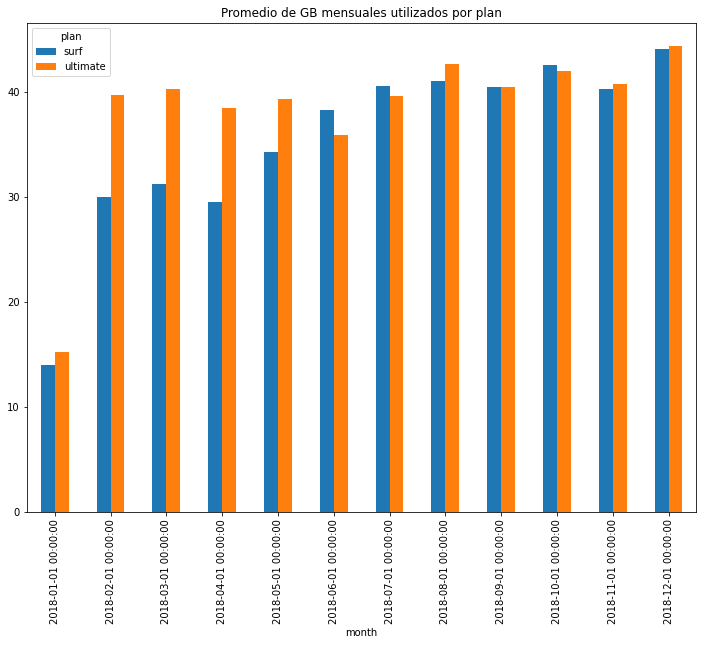

In [69]:
mean_gb_by_month.plot(kind="bar",figsize= (12,9), title= "Promedio de GB mensuales utilizados por plan")

In [70]:
print("la media de consumo de GB de los usuarios Surf es de" , surf_behavior["total_gb_used"].mean())

la media de consumo de GB de los usuarios Surf es de 40.526957637997434


In [71]:
print("la media de consumo de GB de los usuarios Ultimate es de" , ultimate_behavior["total_gb_used"].mean())

la media de consumo de GB de los usuarios Ultimate es de 41.13769123783032


In [72]:
surf_var_gb = surf_behavior["total_gb_used"].var()
surf_std_gb = np.sqrt(surf_var_gb)
print("La varianza entre los Gb totales por usuarios Surf es de",surf_var_gb)
print("La desviación estandar de los datos es ", surf_std_gb)

La varianza entre los Gb totales por usuarios Surf es de 305.7266331272987
La desviación estandar de los datos es  17.485040266676503


In [73]:
ultimate_var_gb = ultimate_behavior["total_gb_used"].var()
ultimate_std_gb = np.sqrt(ultimate_var_gb)
print("La varianza entre los Gb totales por usuarios ultimate es de",ultimate_var_gb)
print("La desviación estandar de los datos es ", ultimate_std_gb)

La varianza entre los Gb totales por usuarios ultimate es de 271.2247473084329
La desviación estandar de los datos es  16.46890243180865


<AxesSubplot:xlabel='total_gb_used'>

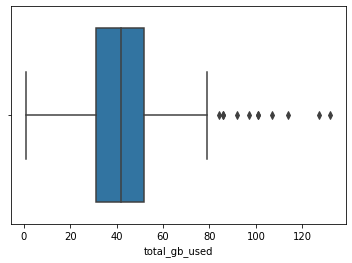

In [74]:
sns.boxplot(x=surf_behavior["total_gb_used"])

<AxesSubplot:xlabel='total_gb_used'>

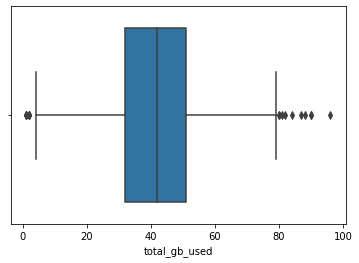

In [75]:
sns.boxplot(x=ultimate_behavior["total_gb_used"])

En este caso parece que la media de usuarios del plan "ultimate" parece tener un mayor consumo de datos con respecto al plan surf, esto se reflejara en los ingresos. ya que los usuarios "surf" parecen consumir lo mismo que los de "ultimate". Nuevamente esta información es valiosa para un equipo de marketing para mejorar los planes a ese sector de usuarios "surf" que consumen más datos.

## Ingreso

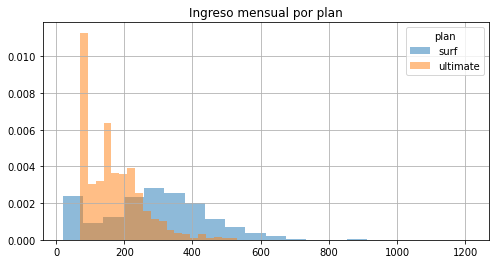

In [76]:
plt.figure(figsize=(8,4))
surf_behavior["income"].hist(ax=plt.gca(),bins=20, density=True, alpha=0.5, label="surf")
ultimate_behavior["income"].hist(ax=plt.gca(),bins=20, density=True, alpha=0.5, label="ultimate")
plt.legend(title="plan")
plt.title("Ingreso mensual por plan")
plt.show()

In [77]:
total_income_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "income",
                                                   aggfunc='sum'
) 

<AxesSubplot:title={'center':'Total de ingresos mensuales utilizados por plan'}, xlabel='month'>

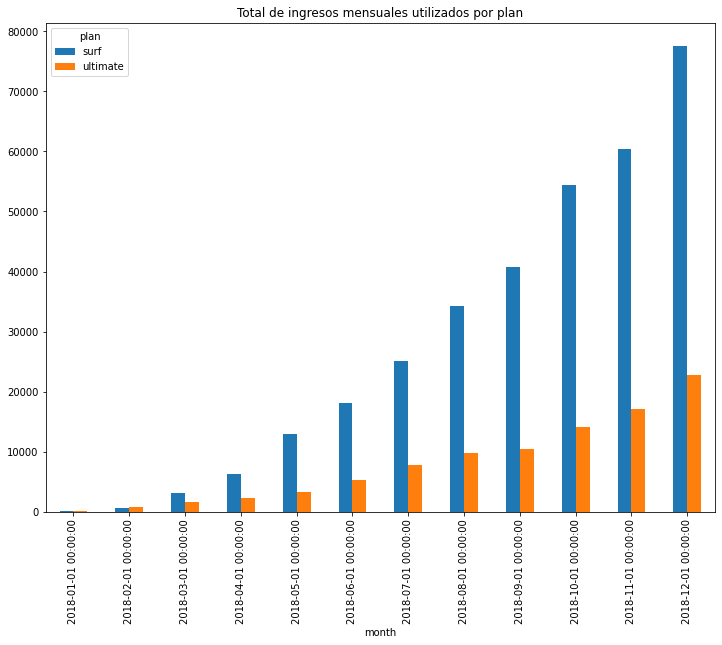

In [78]:
total_income_by_month.plot(kind="bar",figsize= (12,9), title= "Total de ingresos mensuales utilizados por plan")

In [79]:
mean_income_by_month = behavior_data.pivot_table(index= "month",
                                                   columns= "plan",
                                                   values= "income",
                                                   aggfunc='mean'
) 

<AxesSubplot:title={'center':'Promedio de ingresos mensuales utilizados por plan'}, xlabel='month'>

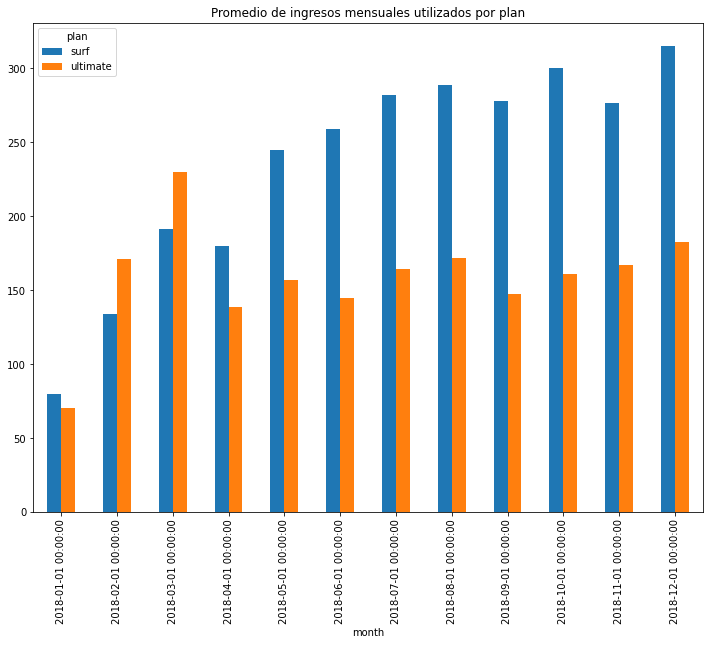

In [80]:
mean_income_by_month.plot(kind="bar",figsize= (12,9), title= "Promedio de ingresos mensuales utilizados por plan")

Podemos observar que en el caso del ingreso mensual, la mayor parte de los usuarios del plan ultimate, pagan su tarifa base, mientras que los usuarios "surf" tienden a realizar pagos extras por exeder los limites de su plan.

In [81]:
print("El ingreso promedio por parte de los usuarios Surf es de" , surf_behavior["income"].mean())

El ingreso promedio por parte de los usuarios Surf es de 282.8226186440678


In [82]:
print("El ingreso promedio por parte de los usuarios Ultimate es de" , ultimate_behavior["income"].mean())

El ingreso promedio por parte de los usuarios Ultimate es de 165.07426597582037


In [83]:
surf_var_income = surf_behavior["income"].var()
surf_std_income = np.sqrt(surf_var_gb)
print("La varianza entre los ingresos totales por usuarios Surf es de",surf_var_income)
print("La desviación estandar de los datos es ", surf_std_income)

La varianza entre los ingresos totales por usuarios Surf es de 25498.17274911653
La desviación estandar de los datos es  17.485040266676503


In [84]:
ultimate_var_income = ultimate_behavior["income"].var()
ultimate_std_income = np.sqrt(ultimate_var_income)
print("La varianza entre los ingresos totales por usuarios ultimate es de",ultimate_var_income)
print("La desviación estandar de los datos es ", ultimate_std_income)

La varianza entre los ingresos totales por usuarios ultimate es de 7160.345686095224
La desviación estandar de los datos es  84.6188258373704


Como se puede observar en el gráfico de barras "Total de ingresos mensuales utilizados por plan" los ingresos por los usuarios del plan Surf son mayores. Esto se puede deber a dos factores, la cantidad de usuarios en cada plan, y en segundo lugar a los valores que se encuentran fuera de Q3 que representa el exedente que pagan por exceder los servicios incluidos en el plan.
En cualquiera de los casos, los datos de ingresos por el plan surf se encuentran muy dispersos por lo que existen personas a las cuales les seria mas util contratar un servicio ultimate.


<AxesSubplot:xlabel='income'>

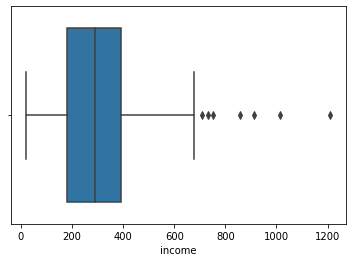

In [85]:
sns.boxplot(x=surf_behavior["income"])

<AxesSubplot:xlabel='income'>

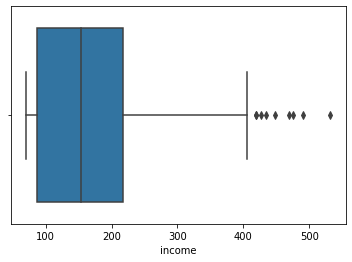

In [86]:
sns.boxplot(x=ultimate_behavior["income"])

Como se puede observar en el diagrama de bigotes, en el caso de los usuarios del plan "surf" tienden a pagar más sobre su plan, ya que se puede obsevar que hay mucho más datos fuera de Q3. Mientras que en el plan "ultimate" existen algunos usuarios fuera de Q3. Seria interesante analizar este sector de usuarios. 

## Prueba las hipótesis estadísticas

In [87]:
# Prueba las hipótesis

behavior_data.groupby("plan")["income"].mean()

plan
surf        282.822619
ultimate    165.074266
Name: income, dtype: float64

la media es diferente por lo que la hipotesis nula se rechaza.

In [88]:

#behavior_data=behavior_data

alpha= 0.05

results = st.ttest_ind(
    behavior_data.dropna().query('plan=="surf"')["income"],
    behavior_data.dropna().query('plan=="ultimate"')["income"],
    equal_var = False
)

print('valor p:', results.pvalue)

if (results.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p: 1.0052255610544789e-81
Rechazamos la hipótesis nula


In [89]:
# Prueba las hipótesis
behavior_data[behavior_data["city"].str.contains("New York")]["city"].unique()


array(['New York-Newark-Jersey City, NY-NJ-PA MSA'], dtype=object)

In [90]:
ny_nj_zones= [
    "New York-Newark-Jersey City, NY-NJ-PA MSA",
]

In [91]:
alpha= 0.05
results_ny =ttest_ind(
    behavior_data[behavior_data["city"].isin(ny_nj_zones)]["income"],
          behavior_data[~behavior_data["city"].isin(ny_nj_zones)]["income"]
         )

print('valor p:', results.pvalue)

if (results_ny.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p: 1.0052255610544789e-81
No podemos rechazar la hipótesis nula


## Conclusión general



En este proyecto, se creo un apartado para todas la bibliotecas que se ocuparon durante la realización del mismo, posteriormente, se realizaron las cargas de datos, los cuales venian en formato estandar CSV y no tuvo que realizarse ningun cambio a los parametros de carga.
En la exploración de nuestra información descubrimos que algunas columnas debian ser cambiadas a formato de fecha para poder utilizarlas en operaciones y filtros, al igual que se realizo el cambio de mb a gb, ya que la tarifa se encuentra dada en gb.
Posteriormente, procedimos a unir nuestras tablas mediante merge, esto con el objetivo de poder calcular el ingreso total por usuario, asi obteniendo una tabla consolidada con los valores de los ingresos por cada cliente.

En las pruebas estadisticas, anilizamos cada uno de lso servicios y comparamos sus acumulados por mes y por el plan al que pertenecen, mediante la creación de una tabla dinamica, que nos permitio acomodar y resumir el dataframe que contenia toda la información a una tabla que se utilizo para graficar, con un grafico de barras. Y asi poder comparar el comportamiento de los planes a través de los meses.

Finalmente se crearon hipotesis para ver la diferencia entre ambas varianzas, se utilizo T-student debido al tamaño de la muestra, y en otro caso se creo un filtro para solo trabajar con los valores de la ciudad de NewYork y obtener un pvalue. 

Con la información recolectada podemos concluir que hay un sector de las personas del plan surf que podrian ser buenos prospectos para cambiarse al plan ultimate, lo cual generaria un 


En general, hemos aplicado varias funciones y herramientas que hemos visto desde el inicio del curso y las hemos ido integrando, al igual que cada vez los proyectos tienen menos información y solo dan la tarea en general a realizar, lo cual nos ayuda a ir adaptandonos a lo que se tendria que entregar en un proyecto real.
